This notebook explains how to run a simple 2-dimension example of Diva.<br>
The input files and the figures are created within the notebook.<br>
The reading/writing of input files is done through specific classes defined in [pydiva2d](./pydiva2d.py).

In [1]:
import os
import logging
import shutil
import subprocess
import numpy as np
import pydiva2d

# Setup 

## Logging configuration

The *logging* is already configured in *pydiva2d*.<br>
Replace 'DEBUG' by 'INFO', 'WARNING' or 'ERROR'.

In [2]:
logger = logging.getLogger('pydiva2d')
logger.handlers[1].setLevel(logging.DEBUG)

## Diva configuration

Set the path to the Diva installation you want to work with.

In [3]:
divadir = "/home/ctroupin/Software/DIVA/DIVA-diva-4.7.1"

# Prepare the input files

## Directories

Create variables storing the Diva directories.

In [4]:
DivaDirs = pydiva2d.DivaDirectories(divadir)

2017-04-07 13:33:43,005 - pydiva2d - DEBUG - /home/ctroupin/Software/DIVA/DIVA-diva-4.7.1 exists
2017-04-07 13:33:43,007 - pydiva2d - INFO - Diva main directory: /home/ctroupin/Software/DIVA/DIVA-diva-4.7.1
2017-04-07 13:33:43,009 - pydiva2d - INFO - Creating Diva directory paths
2017-04-07 13:33:43,010 - pydiva2d - INFO - Binary directory:   /home/ctroupin/Software/DIVA/DIVA-diva-4.7.1/DIVA3D/bin
2017-04-07 13:33:43,011 - pydiva2d - INFO - Source directory:   /home/ctroupin/Software/DIVA/DIVA-diva-4.7.1/DIVA3D/src/Fortran
2017-04-07 13:33:43,013 - pydiva2d - INFO - Main 2D directory:  /home/ctroupin/Software/DIVA/DIVA-diva-4.7.1/DIVA3D/divastripped
2017-04-07 13:33:43,014 - pydiva2d - INFO - Main 4D directory:  /home/ctroupin/Software/DIVA/DIVA-diva-4.7.1/JRA4/Climatology


Create variables storing the Diva input and output files.

In [5]:
DivaFiles = pydiva2d.Diva2Dfiles(DivaDirs.diva2d)

2017-04-07 13:33:43,317 - pydiva2d - INFO - Creating Diva 2D file names and paths
2017-04-07 13:33:43,324 - pydiva2d - INFO - Contour file:   /home/ctroupin/Software/DIVA/DIVA-diva-4.7.1/DIVA3D/divastripped/input/coast.cont
2017-04-07 13:33:43,326 - pydiva2d - INFO - Parameter file: /home/ctroupin/Software/DIVA/DIVA-diva-4.7.1/DIVA3D/divastripped/input/param.par
2017-04-07 13:33:43,331 - pydiva2d - INFO - Data file:      /home/ctroupin/Software/DIVA/DIVA-diva-4.7.1/DIVA3D/divastripped/input/data.dat
2017-04-07 13:33:43,332 - pydiva2d - INFO - Valatxy file:   /home/ctroupin/Software/DIVA/DIVA-diva-4.7.1/DIVA3D/divastripped/input/valatxy.coord
2017-04-07 13:33:43,333 - pydiva2d - INFO - Result file:    /home/ctroupin/Software/DIVA/DIVA-diva-4.7.1/DIVA3D/divastripped/output/ghertonetcdf/results.nc
2017-04-07 13:33:43,335 - pydiva2d - INFO - Mesh file:      /home/ctroupin/Software/DIVA/DIVA-diva-4.7.1/DIVA3D/divastripped/meshgenwork/fort.22
2017-04-07 13:33:43,336 - pydiva2d - INFO - Mesh 

## Contour

Create a sequence of points representing the contour (no crossing, no duplicate points, etc).<br>
It is not necessary to close the contour (i.e., setting the last point equal to the first point).<br>
Each coordinate (lon, lat) is defined as a [ndarray](https://docs.scipy.org/doc/numpy/reference/arrays.ndarray.html).

In [6]:
lon = np.array([[0., 2., 2., 0.], [2.5, 6., 6., 2.5]])
lat = np.array([[0., 0., 4., 4.], [0., 0., 3., 3.]]) 

Create a **contour** object using the coordinates: 

In [7]:
contour2D = pydiva2d.Diva2DContours(lon, lat)

2017-04-07 13:33:44,403 - pydiva2d - INFO - Creating Diva 2D contour object


and write its content to the corresponding file defined in the **DivaFile** object:

In [8]:
contour2D.write_to(DivaFiles.contour)

2017-04-07 13:33:44,738 - pydiva2d - INFO - Number of contours: 2
2017-04-07 13:33:44,745 - pydiva2d - INFO - Number of contours: 2
2017-04-07 13:33:44,749 - pydiva2d - DEBUG - Sub-contour no. 1 has 4 points
2017-04-07 13:33:44,751 - pydiva2d - DEBUG - Sub-contour no. 2 has 4 points
2017-04-07 13:33:44,752 - pydiva2d - INFO - Written contours into file /home/ctroupin/Software/DIVA/DIVA-diva-4.7.1/DIVA3D/divastripped/input/coast.cont


## Data

Create arrays of coordinates (*x*, *y*), values (*z*) and optionnaly weights (*w*) representing the data points.<br>
If the weights are not specified, it is assumed that all the data points have an identical weight (equal to 1).

In [9]:
x = np.array((1.2, 1.75, 3., 5.5))  
y = np.array((2.1, 3.5, 2., 0.2))
z = np.array((1., -2., 4, -1))
w = np.array((1., 1., 0.5, 0.5))

Similarly to the contour, we create a **data** object:

In [10]:
data2D = pydiva2d.Diva2DData(x, y, z, w)

2017-04-07 13:33:47,036 - pydiva2d - INFO - Creating Diva 2D data object
2017-04-07 13:33:47,041 - pydiva2d - INFO - Setting weights to data points


and we write the values to the specified file:

In [11]:
data2D.write_to(DivaFiles.data)

2017-04-07 13:33:47,681 - pydiva2d - INFO - Written data into file /home/ctroupin/Software/DIVA/DIVA-diva-4.7.1/DIVA3D/divastripped/input/data.dat


## Parameters

We need to set the parameters defining the domain and the analysis parameters.<br>
Check the [documentation](http://modb.oce.ulg.ac.be/mediawiki/index.php/Diva_documents#User_guides) to have a complete description of each parameter.

First we set the output grid (limits and spatial resolution).

In [12]:
xmin, ymin, nx, ny, dx, dy = 0.0, 0.0, 61, 81, 0.1, 0.05

Then the parameters specific to the analysis:

In [13]:
CorrelationLength = 1.5
SignalToNoiseRatio = 0.5
VarianceBackgroundField = 1.0
ExclusionValue = -999.
iCoordChange = 0
iSpec = 11
iReg = 0

We create a **parameter** object that stores all the parameter values:

In [14]:
parameters2D = pydiva2d.Diva2DParameters(CorrelationLength, iCoordChange, iSpec, iReg, xmin, ymin, dx, dy, nx, ny,
                                ExclusionValue, SignalToNoiseRatio, VarianceBackgroundField)

2017-04-07 13:33:50,241 - pydiva2d - INFO - Creating Diva 2D parameter object


and we write them into a file:

In [15]:
parameters2D.write_to(DivaFiles.parameter)

2017-04-07 13:33:50,929 - pydiva2d - INFO - Written parameters into file /home/ctroupin/Software/DIVA/DIVA-diva-4.7.1/DIVA3D/divastripped/input/param.par


## List of extra points

In the optional input file *valatxy.coord*, one can specify additional locations where the interpolation has to be performed.<br>
Here we ask for the analysis at the location of the first two data points, plus at an additional location.

In [16]:
xcoord = np.array((1.2, 1.75, 5.9))  
ycoord = np.array((2.1, 3.5, 3.9))

We create the object **valatxy** and write the coordinates to a file:

In [17]:
valatxy = pydiva2d.Diva2DValatxy(xcoord, ycoord)
valatxy.write_to(DivaFiles.valatxy)

2017-04-07 13:33:53,305 - pydiva2d - INFO - Creating Diva 2D valatxy object
2017-04-07 13:33:53,310 - pydiva2d - INFO - Written locations into file /home/ctroupin/Software/DIVA/DIVA-diva-4.7.1/DIVA3D/divastripped/input/valatxy.coord


# Run Diva

Now that the input files have been created we can perform a Diva analysis.

## Mesh generation

In [18]:
logger.info("Starting generation of the finite-element mesh")
meshprocess = subprocess.Popen("./divamesh", cwd=DivaDirs.diva2d, stdout=subprocess.PIPE, shell=True)
out = meshprocess.stdout.read()
with open(pydiva2d.logfile, 'a') as f:
    f.write(str(out).replace('\\n', '\n'))
logger.info("Finished generation of the finite-element mesh")

2017-04-07 13:33:56,119 - pydiva2d - INFO - Starting generation of the finite-element mesh
2017-04-07 13:33:56,152 - pydiva2d - INFO - Finished generation of the finite-element mesh


## Run the diva calculation

In [19]:
logger.info("Starting computation of the gridded field")
calcprocess = subprocess.Popen("./divacalc", cwd=DivaDirs.diva2d, stdout=subprocess.PIPE, shell=True)
out = calcprocess.stdout.read()
with open(pydiva2d.logfile, 'a') as f:
    f.write(str(out).replace('\\n', '\n'))
logger.info("Finished computation of the gridded field")

2017-04-07 13:33:57,424 - pydiva2d - INFO - Starting computation of the gridded field
2017-04-07 13:33:57,545 - pydiva2d - INFO - Finished computation of the gridded field


# Time for some plots

We import a few more modules to plot the input files content and the results.<br>
The last line asks for the plot to be done within the notebook, not as external window.

In [57]:
import netCDF4
import matplotlib.pyplot as plt
from matplotlib import rcParams
%matplotlib inline

In [58]:
rcParams.update({'font.size': 12, 'figure.dpi': 300})

## Input files

Let's represent the observations, the grid and the contours.<br>
By default, each contour is represented in a different color.

2017-04-07 13:38:27,447 - pydiva2d - DEBUG - No projection defined
2017-04-07 13:38:27,450 - pydiva2d - DEBUG - Adding contours to plot
2017-04-07 13:38:27,497 - pydiva2d - DEBUG - No projection defined
2017-04-07 13:38:27,498 - pydiva2d - DEBUG - Adding data points to plot
2017-04-07 13:38:27,504 - pydiva2d - DEBUG - Adding output grid to plot


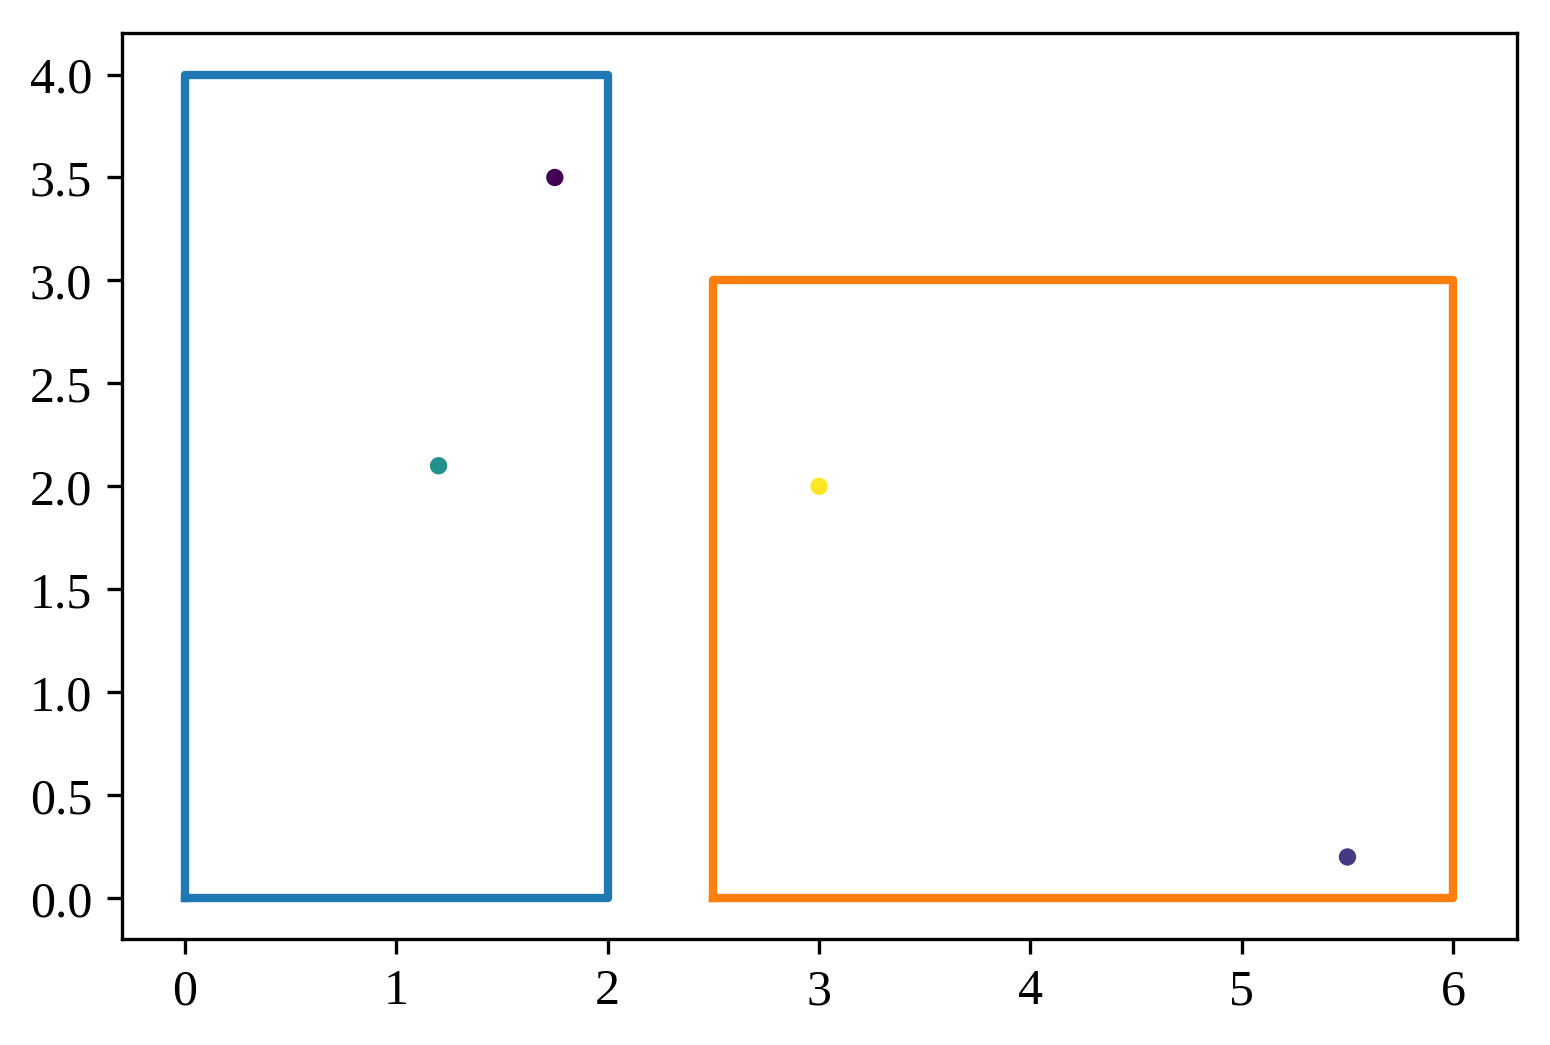

In [59]:
fig = plt.figure()
contour2D.add_to_plot(linewidth=2)
data2D.add_to_plot(s=10)
parameters2D.plot_outputgrid()
plt.show()
plt.close()

## Results 

The results are stored in a netCDF file that we can access using the **resultfile** property of **DivaFile** object.

### Analysis

The field is then added to the plot. In addition we can include the locations of the observations.<br>
Note that, due to their lower weights, the 2 data points in the right-side domain seems to influence less the analysis.

2017-04-07 13:51:54,289 - pydiva2d - DEBUG - No projection defined
2017-04-07 13:51:54,291 - pydiva2d - DEBUG - Adding analysed field to plot
2017-04-07 13:51:54,330 - pydiva2d - DEBUG - No projection defined
2017-04-07 13:51:54,331 - pydiva2d - DEBUG - Adding data points to plot


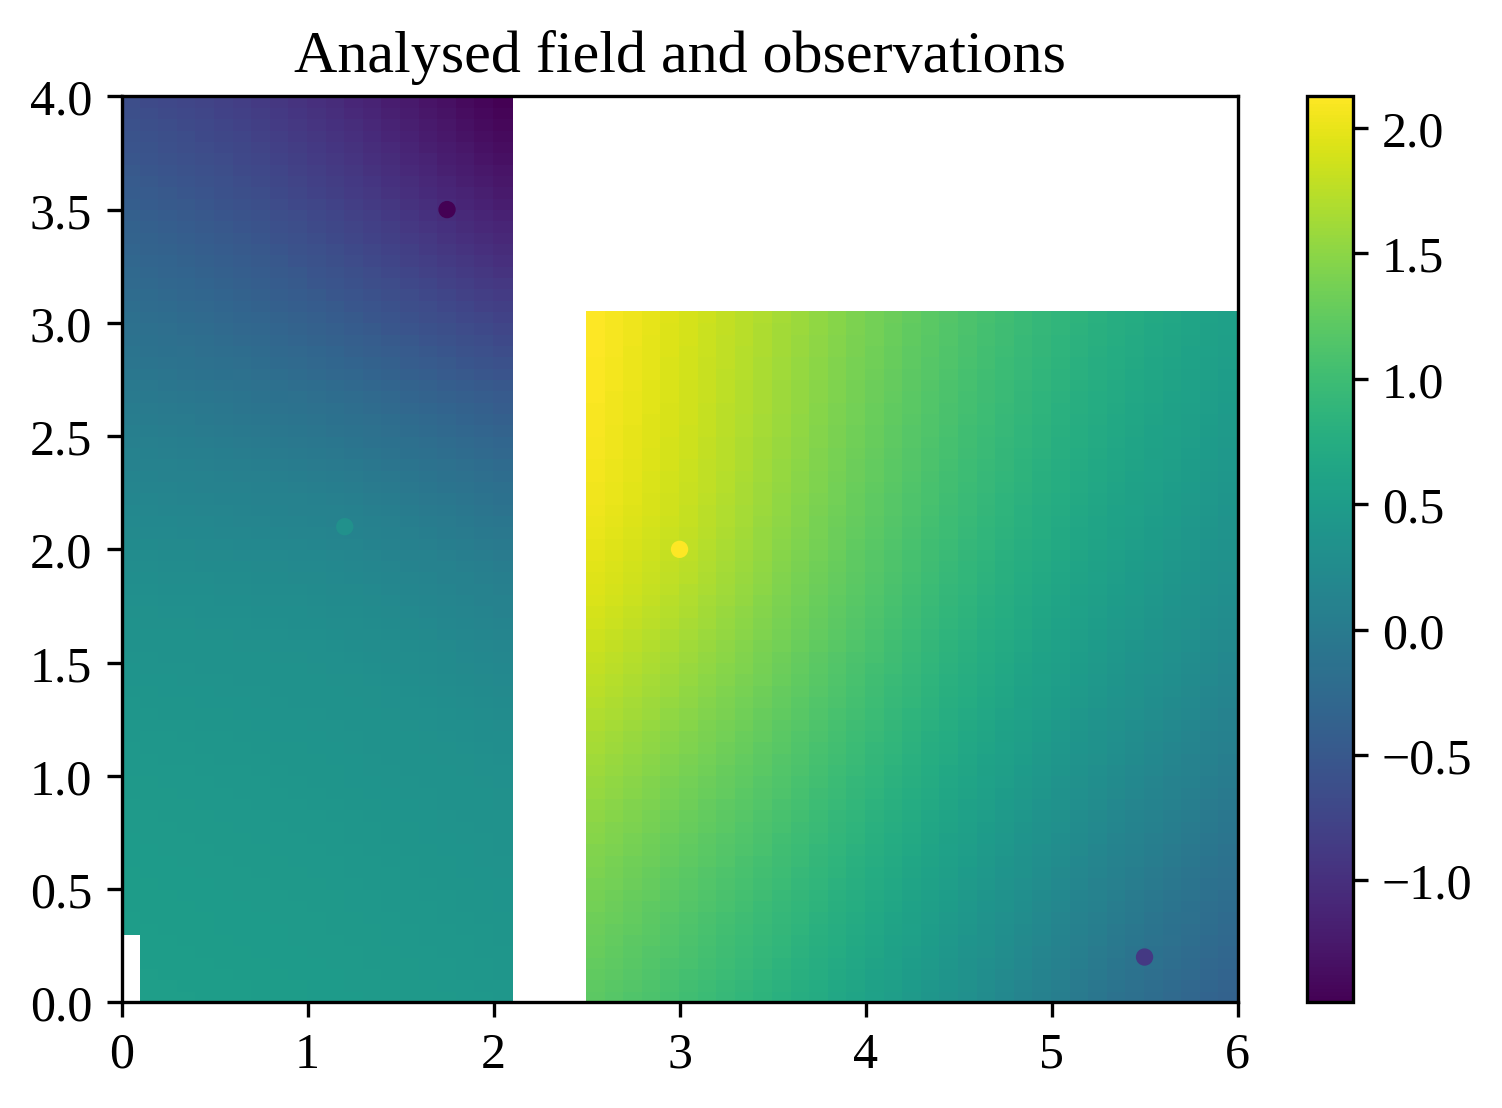

In [75]:
fig = plt.figure()
results2D = pydiva2d.Diva2DResults(DivaFiles.result)
fieldplot = results2D.add_to_plot('result')
data2D.add_to_plot(s=10)
plt.colorbar(fieldplot)
plt.title('Analysed field and observations')
plt.show()
plt.close()

### Error field

The error field is represented using a similar command.<br>
Also note the larger error values in the right-hand side, due to the lower weights of the data points in that part of the domain.

2017-04-07 13:59:37,792 - pydiva2d - DEBUG - No projection defined
2017-04-07 13:59:37,793 - pydiva2d - DEBUG - Adding error field to plot
2017-04-07 13:59:37,796 - pydiva2d - DEBUG - Adding data positions to plot


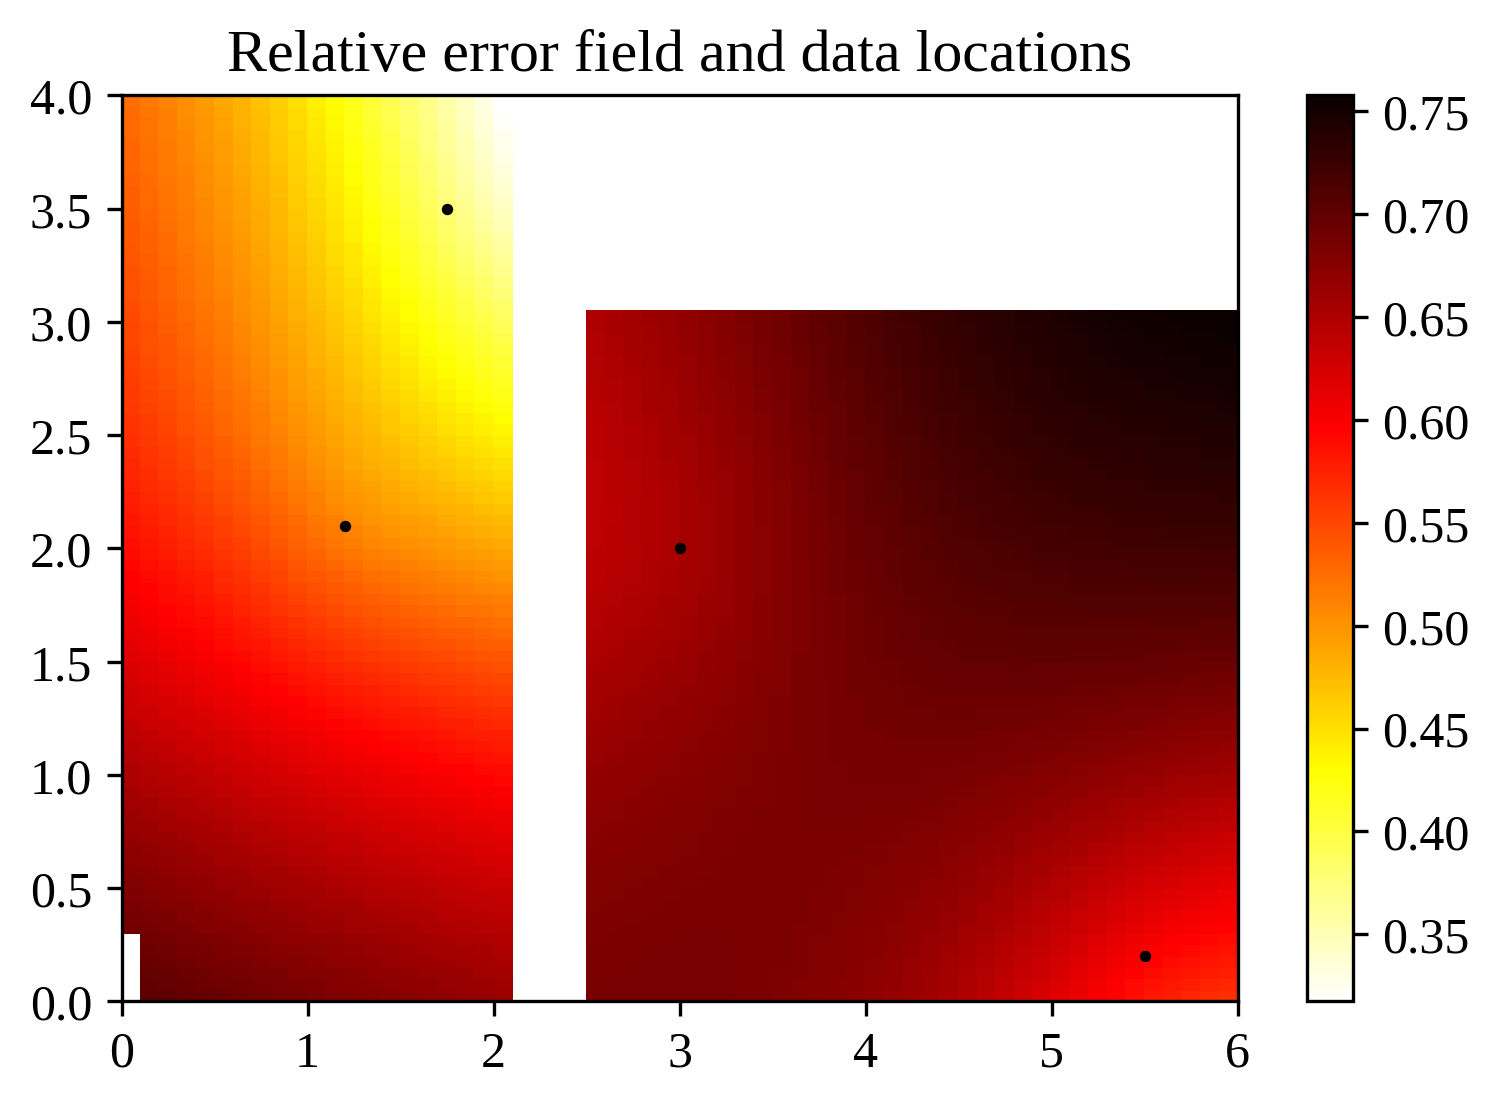

In [87]:
fig = plt.figure()
ax = plt.subplot(111)
errorfield = results2D.add_to_plot(ax, field='error', cmap=plt.cm.hot_r)
data2D.add_positions_to_plot(s=3, color='k')
plt.colorbar(errorfield)
plt.title('Relative error field and data locations')
plt.show()
plt.close()

## Finite-element mesh

It is also interesting to display the finite-element mesh that covers our domain of interest.<br>
First we create a `Mesh` object, then we read the mesh from the 2 corresponding files.

In [92]:
mesh2D = pydiva2d.Diva2DMesh()
mesh2D.read_from(DivaFiles.mesh, DivaFiles.meshtopo)

2017-04-07 14:00:51,277 - pydiva2d - INFO - Creating Diva 2D mesh object


The plot is prepared with the add_to_plot method:

2017-04-07 14:05:11,128 - pydiva2d - DEBUG - No projection defined
2017-04-07 14:05:11,129 - pydiva2d - DEBUG - Adding finite-element mesh to plot
2017-04-07 14:05:11,133 - pydiva2d - DEBUG - Setting limits to axes
2017-04-07 14:05:11,134 - pydiva2d - DEBUG - No projection defined
2017-04-07 14:05:11,135 - pydiva2d - DEBUG - Adding contours to plot


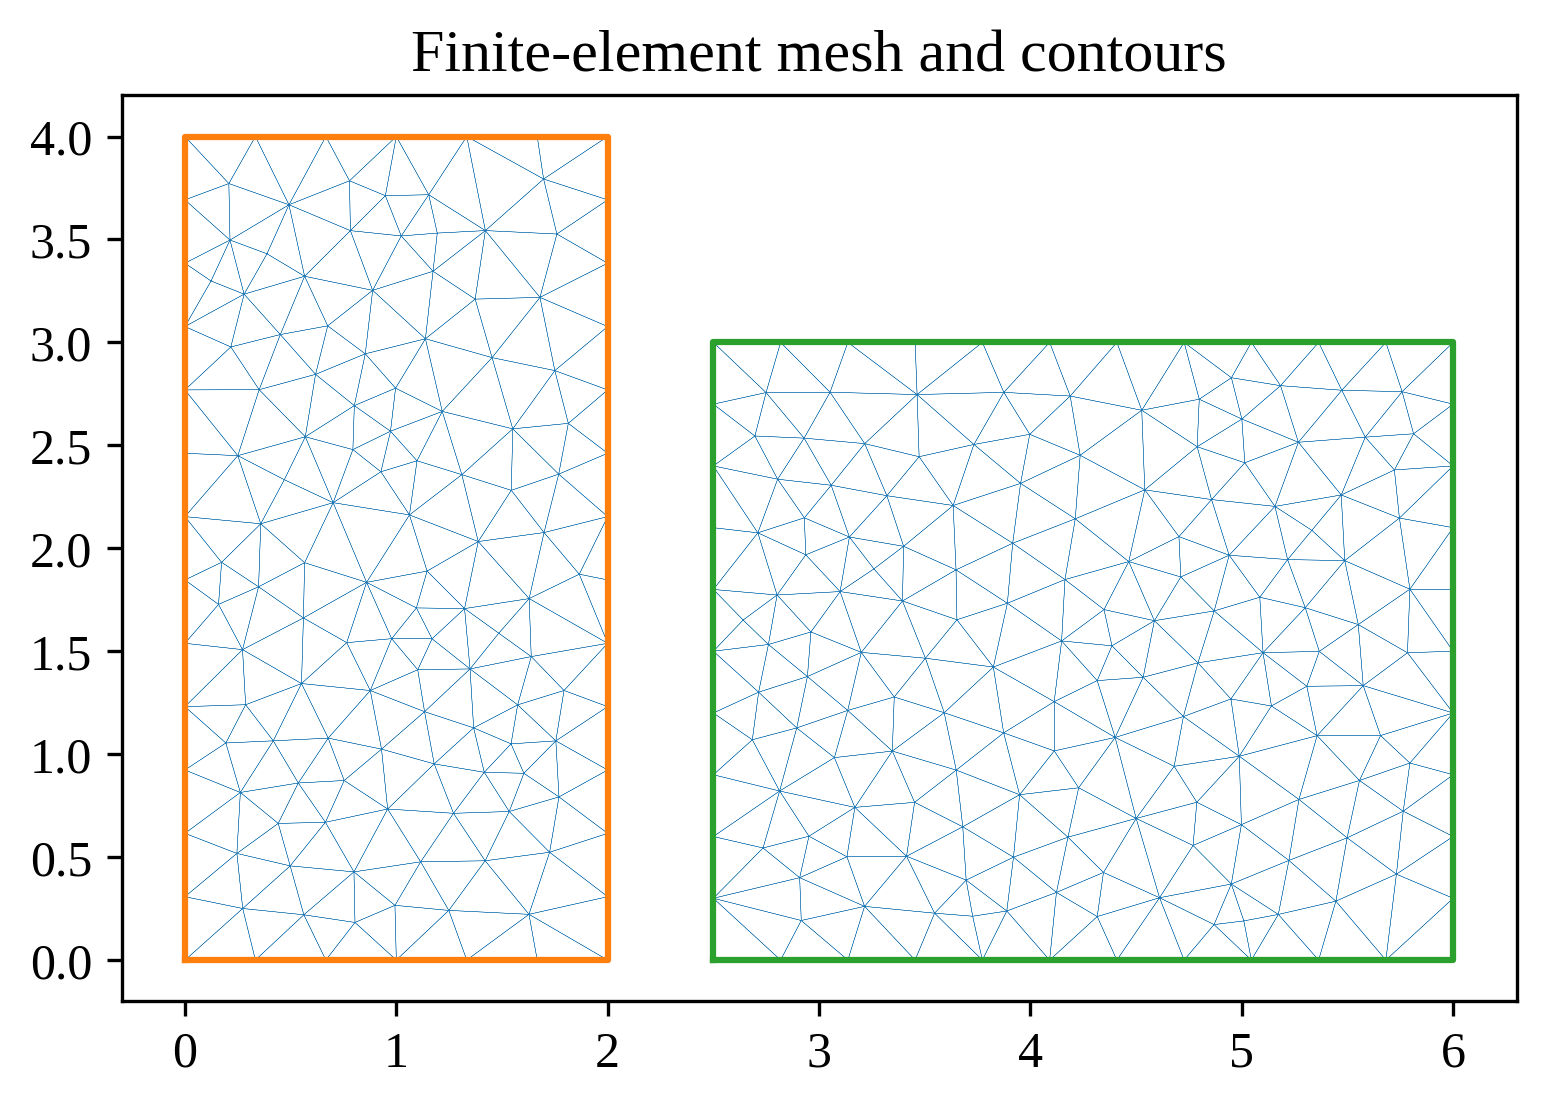

In [102]:
fig = plt.figure()
ax = fig.add_subplot(111)
mesh2D.add_to_plot(lw=0.1)
contour2D.add_to_plot()
plt.title('Finite-element mesh and contours')
plt.show()
plt.close()

In [94]:
mesh2D.describe()

Number of nodes: 325
Number of interfaces: 889
Number of elements: 566
